# Loop Hydrodynamics
Configure loop hydrodynamics with HYDRAD. We need to write an interface to the HYDRAD model that can both configure the simulations and load the results back in

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import astropy.units as u
import astropy.constants as const
import sunpy.sun.constants as sun_const
from scipy.interpolate import splrep,splev

from hydrad_tools.configure import Configure
from hydrad_tools.parse import Strand

import synthesizAR
from synthesizAR.interfaces.ebtel import power_law_transform,calculate_free_energy


%matplotlib inline

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/hydrad_tools/configure/configure.py:20: UserWarning: GitPython not installed. Cannot retrieve base copy from GitHub.
  warnings.warn('GitPython not installed. Cannot retrieve base copy from GitHub.')
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
active_region = synthesizAR.Field.restore('/storage-home/w/wtb2/data/hi_c_simulation/noaa12712_base/')

## HYDRAD Interface
The first thing we need to do is set up an interface to HYDRAD.

In [3]:
class HYDRADInterface(object):
    
    def __init__(self,base_config,hydrad_dir,output_dir):
        self.name = 'HYDRAD'
        self.base_config = base_config
        self.hydrad_dir = hydrad_dir
        self.output_dir = output_dir
        self.duration = 200.0 * u.s
        self.stress = 0.3
        self.max_grid_cell = 1e8*u.cm
    
    def configure_input(self,loop):
        config = self.base_config.copy()
        # General configuration
        config['general']['loop_length'] = loop.full_length
        config['initial_conditions']['heating_location'] = loop.full_length / 2.
        config['grid']['minimum_cells'] = int(loop.full_length / self.max_grid_cell)
        # Gravity and cross-section coefficients
        config['general']['tabulated_gravity_profile'] = self.get_gravity_coefficients(loop)
        config['general']['tabulated_cross_section_profile'] = self.get_cross_section_coefficients(loop)
        # Heating configuration
        events = []
        rates = self.get_heating_rates(loop)
        twaits = self.get_waiting_times(rates)
        cumulative_time = 0*u.s
        for r,t in zip(rates,twaits):
            events.append({
                'time_start': cumulative_time.copy(),
                'rise_duration': self.duration/2.,
                'decay_duration': self.duration/2.,
                'total_duration': self.duration,
                'location': loop.full_length / 2.,
                'scale_height': 1e300*u.cm,
                'rate': r,
            })
            cumulative_time += t + self.duration
        # Set the heating events here
        config['heating']['events'] = events
        # Setup configuration, run IC code
        c = Configure(config)
        c.setup_simulation(self.output_dir,base_path='/storage-home/w/wtb2/codes/HYDRAD/',name=loop.name,verbose=False)
    
    def load_results(self,loop):
        # return time, electron_temperature, ion_temperature, density, velocity
        pass
    
    def get_cross_section_coefficients(self, loop):
        s_norm = loop.field_aligned_coordinate / loop.full_length
        return np.polyfit(s_norm, loop.field_strength, 6)[::-1]
    
    def get_gravity_coefficients(self, loop):
        s_norm = loop.field_aligned_coordinate / loop.full_length
        s_hat = (np.gradient(loop.coordinates.cartesian.xyz, axis=1) 
                 / np.linalg.norm(np.gradient(loop.coordinates.cartesian.xyz, axis=1), axis=0))
        r_hat = u.Quantity(np.stack([np.sin(loop.coordinates.spherical.lat)*np.cos(loop.coordinates.spherical.lon),
                                     np.sin(loop.coordinates.spherical.lat)*np.sin(loop.coordinates.spherical.lon),
                                     np.cos(loop.coordinates.spherical.lat)]))
        g_parallel = -sun_const.surface_gravity.cgs * ((const.R_sun.cgs / loop.coordinates.spherical.distance)**2) * (r_hat * s_hat).sum(axis=0)
        return np.polyfit(s_norm, g_parallel, 6)[::-1]
    
    def get_average_waiting_time(self,loop):
        # Approximate the loop cooling time
        return loop.full_length / (80*u.Mm) * 4000*u.s 
    
    def get_number_events(self,loop):
        twait = self.get_average_waiting_time(loop)
        return int(np.ceil(base_config['general']['total_time'] / (self.duration + twait)))
    
    def get_heating_rates(self,loop):
        rate_max = (self.stress * loop.field_strength.max().value)**2 / (8.*np.pi) * u.erg / (u.cm**3)
        rate_max /= (self.duration / 2.)
        rate_min = rate_max / 100.0
        return power_law_transform(np.random.rand(self.get_number_events(loop)), rate_min, rate_max, -2.5) 
    
    def get_waiting_times(self, rates):
        prop_const = (self.base_config['general']['total_time'] - rates.shape[0] * self.duration) / rates.sum()
        return rates * prop_const


## Configure Loop Simulations

First, setup a base configuration dictionary. These are the options that won't change from loop to loop.

In [4]:
base_config = {
    'general': {
        'total_time': 5e4 * u.s,
        #'loop_length': 80 * u.Mm,
        'footpoint_height': 5e8 * u.cm,
        'output_interval': 5*u.s,
        'loop_inclination': 0*u.deg,
        'logging_frequency': 1000,
        'write_file_physical': True,
        'write_file_ion_populations': False,
        'write_file_hydrogen_level_populations': False,
        'write_file_timescales': False,
        'write_file_equation_terms': False,
        'heat_flux_limiting_coefficient': 1./6.,
        'heat_flux_timestep_limit': 1e-10*u.s,
        'use_kinetic_model': False,
        'minimum_collisional_coupling_timescale': 0.01*u.s,
        'force_single_fluid': False,
        #'tabulated_gravity_profile':,
        #'tabulated_cross_section_profile':,
    },
    'initial_conditions': {
        'footpoint_temperature': 2e4 * u.K,
        'footpoint_density': 1e11 * u.cm**(-3),
        'isothermal': False,
        #'heating_location':,
        'heating_scale_height': 1e300*u.cm,
        'heating_range_lower_bound': 1e-8*u.erg/u.s/(u.cm**3),
        'heating_range_upper_bound': 1e2*u.erg/u.s/(u.cm**3),
        'heating_range_step_size': 0.01,
        'heating_range_fine_tuning': 10000.0,
        'use_tabulated_gravity': False,
    },
    'radiation': {
        'use_power_law_radiative_losses': True,
        'decouple_ionization_state_solver': False,
        'density_dependent_rates': False,
        'optically_thick_radiation': False,
        'nlte_chromosphere': False,
        'ranges_dataset': 'ranges',
        'emissivity_dataset': 'chianti_v7',
        'abundance_dataset': 'asplund',
        'rates_dataset': 'chianti_v7',
        'elements_equilibrium': ['Fe'],
        'elements_nonequilibrium': [],
    },
    'heating': {
        'heat_electrons': True,
        'background_heating': True,
        'beam_heating': False,
        'alfven_wave_heating': False,
        #'events': [
        #    {'time_start': 0.*u.s, 
        #     'rise_duration': 100*u.s,
        #     'decay_duration': 100*u.s, 
        #     'total_duration': 200*u.s,
        #     'location': 4e9*u.cm, 
        #     'scale_height': 1e300 * u.cm,
        #     'rate': 0.1 *u.erg/u.s/(u.cm**3),},
        #],
    },
    'solver': {
        'epsilon': 0.01,
        'safety_radiation': 0.1,
        'safety_conduction': 1.0,
        'safety_advection': 1.0,
        'safety_atomic': 1.0,
        'safety_viscosity': 1.0,
        'cutoff_ion_fraction':1e-6,
        'epsilon_d':0.1,
        'epsilon_r':1.8649415311920072,
        'timestep_increase_limit': 5*u.percent,
        'relative_viscous_timescale': None,
        'minimum_radiation_temperature': 2e4*u.K,
        'zero_over_temperature_interval': 5.0e2*u.K,
        'minimum_temperature': 1e4*u.K,
        'maximum_optically_thin_density': 1e12*u.cm**(-3),
    },
    'grid': {
        'adapt': True,
        'adapt_every_n_time_steps': 10,
        #'minimum_cells': 150,
        'maximum_cells': 30000,
        'maximum_refinement_level': 12,
        'minimum_delta_s': 1.0*u.cm,
        'maximum_variation': 10*u.percent,
        'refine_on_density': True,
        'refine_on_electron_energy': True,
        'refine_on_hydrogen_energy': False,
        'minimum_fractional_difference': 10*u.percent,
        'maximum_fractional_difference': 20*u.percent,
        'linear_restriction': True,
        'enforce_conservation': False,
    }
} 

Now, instantiate the interface for HYDRAD. We'll use the base configuration we just setup.

In [5]:
interface = HYDRADInterface(base_config, '/storage-home/w/wtb2/codes/HYDRAD/',
                            '/storage-home/w/wtb2/data/hi_c_simulation/hydrodynamics/')

Finally, configure HYDRAD runs for all of our loops.

In [6]:
active_region.configure_loop_simulations(interface)

FloatProgress(value=0.0)

### Sandbox
Check a few results to make sure everything is working ok.

In [119]:
interface.configure_input(active_region.loops[0])

In [151]:
strand0.loop_length.to(u.Mm)

<Quantity 34.99452143 Mm>

In [121]:
strand0 = Strand('/storage-home/w/wtb2/data/hi_c_simulation/hydrodynamics/loop000000/')

0.0 s


(-10000000.0, 10000000.0)

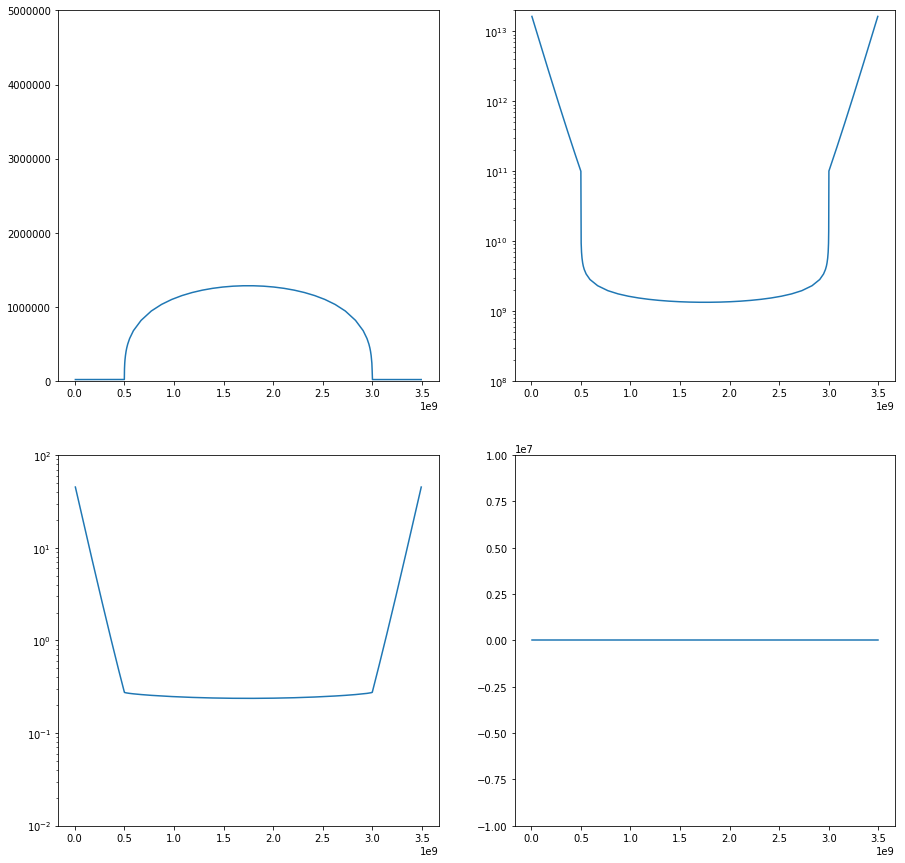

In [149]:
plt.figure(figsize=(15,15))
i_time = 0
print(strand0.time[i_time])
plt.subplot(221) 
plt.plot(strand0[i_time].coordinate, strand0[i_time].electron_temperature)
plt.ylim(0,5e6)
plt.subplot(222)
plt.plot(strand0[i_time].coordinate, strand0[i_time].electron_density)
plt.ylim(1e8,2e13)
plt.yscale('log')
plt.subplot(223)
plt.plot(strand0[i_time].coordinate, strand0[i_time].electron_pressure)
plt.ylim(1e-2,1e2)
plt.yscale('log')
plt.subplot(224)
plt.plot(strand0[i_time].coordinate, strand0[i_time].velocity)
plt.ylim(-1e7,1e7)

## Load in HYDRAD Results